## Imports

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import scipy
import theano.tensor as tt
import matplotlib.pyplot as pplt
from datetime import datetime, timedelta
import math
from scipy.integrate import odeint
from sklearn import preprocessing
import arviz as az
import matplotlib.pyplot as plt

## Functions

In [2]:
# Function used to go back in time with the following format: '%Y-%m-%d'
def minusTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date - timedelta(days = t)
    return d.strftime('%Y-%m-%d')

# Function used to go forward in time with the following format: '%Y-%m-%d'
def addTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date + timedelta(days = t)
    return d.strftime('%Y-%m-%d')

In [3]:
def mcmcSimulation(offset,data, pop, beta, rho):
    # Get the cumulative Death data from the current dataset
    dataDeath = data["cumDeath"].to_numpy()

    # NOTE: doing np.diff will remove the first element of the list
    dataDeath = np.diff(dataDeath)
    
    # Create a context for the t in the SIRD model.
    t = np.linspace(0,len(dataDeath), len(dataDeath))

    # Set up number of samples
    samples = 1000

    # Set up tune in period (burn-in period)
    tune = 1000

    with pm.Model() as model:

        # As we do not have reliable information for i0, we use a weakly-informative prior. (We know that more than 20 infections are present)
        i0 = pm.HalfCauchy('i0', 1)

        # Calculate s0 for each iteration
        s0 = pm.Deterministic('s0', pop - i0)

        # Prior for the recovery rate of COVID-19, note the smaller SD
        γ = pm.LogNormal('γ', math.log(1/8), 0.1)

        # Prior for the mortality rate of COVID-19, note the large SD
        ρ = pm.LogNormal('ρ', math.log(rho), 0.3) 

        # Prior for the infection rate of COVID-19, note the large SD
        β = pm.LogNormal('β', math.log(beta), 0.5) 
 
        # Calculate All the R0 values to obtain CI range
        r0 = pm.Deterministic('R0', β/(γ+ρ))

        # Give scale parameter a level of uncertainty
        # Via HalfCauchy Distribution
        σ = pm.HalfCauchy('σ', beta=1)

        # Generate a sequence of new deaths utilising the current set of parameters for 
        k=i0/s0
        d_cum = pm.Deterministic("Deaths at time:", ρ*(i0*(1+k)**(β/(β-(γ+ρ)))*(1+k*math.e**(β-(γ+ρ))*t)**(-β/(β-(γ+ρ)))*math.e**((β-(γ+ρ))*(t))))

        # create likelihood with modelled counts and observed counts
        obs = pm.StudentT('obs', mu=d_cum, sigma=σ, nu=4, observed=dataDeath)

        # Use the NUTS MCMC sampler
        step=pm.NUTS(target_accept=.99)
        
        # execute sampling
        model_trace = pm.sample(draws=samples, tune=tune, step=step, chains=5, cores=5, idata_kwargs = {'log_likelihood': True}, return_inferencedata = True)
        prior_checks = pm.sample_prior_predictive(samples=1000)
        

    # return posterior samples and other information
    return model_trace, model, dataDeath, prior_checks

In [4]:
# Function utilsied to prepare the df with the right amount of data
# alongside the mean values for beta and rho
def runMCMC(df, population, start_date, end_date, offset, beta, rho):
    mask = (df['date'] >= start_date) & (df['date'] < end_date)
    df = df.loc[mask]
    mcmc = mcmcSimulation(offset,df,population,beta,rho)
    return mcmc    

In [5]:
# printMCMCTables is a function that prints out the tables containing useful informations of the current MCMC model results.
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['β','γ','ρ','σ','R0','i0'], round_to=5))
    return results

PlotMCMC is a function used to display the traceplot of the current model.

In [6]:
# Function used to plot the traceplots of the selected MCMC simulation(s)
def plotMCMC(model, title):
    # ax reprsesents the labels for the different trace plots we will be plotting
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,25))
    ax[0][0].set(ylabel="Density",xlabel="Infection Rate")
    ax[0][1].set(ylabel="Infection Rate",xlabel="Iterations")

    ax[1][0].set(ylabel="Density",xlabel="Recovery Rate")
    ax[1][1].set(ylabel="Recovery Rate",xlabel="Iterations")

    ax[2][0].set(ylabel="Density",xlabel="Mortality Rate")
    ax[2][1].set(ylabel="Mortality Rate",xlabel="Iterations")

    ax[3][0].set(ylabel="Density",xlabel="Reproduction Rate")
    ax[3][1].set(ylabel="Reproduction Rate",xlabel="Iterations")
    plot_trace = pm.plot_trace(model, var_names=('β','γ','ρ','R0'), legend=True, chain_prop={"color":"rgbym"},figsize=(10.0,15.0), axes=ax)
    plt.savefig(title+'.png',  bbox_inches='tight')
    plt.close()
    return plot_trace

In [7]:
def sensitivityAnalysis(model, country, pop):
     # Run Posterior Predictive Sampling
    with model[1]:
        ppc = pm.sample_posterior_predictive(model[0], var_names=["obs",'β','γ','ρ',"i0"])
    beta_samples = ppc["β"]
    gamma_samples = ppc["γ"]
    rho_samples = ppc["ρ"]
    I0_samples = ppc["i0"]

    beta_lower, beta_upper = np.percentile(beta_samples, [5, 95])
    gamma_lower, gamma_upper = np.percentile(gamma_samples, [5, 95])
    mu_lower, mu_upper = np.percentile(rho_samples, [5, 95])

    num_perturbations = 10
    beta_perturbations = np.linspace(beta_lower, beta_upper, num_perturbations)
    gamma_perturbations = np.linspace(gamma_lower, gamma_upper, num_perturbations)
    mu_perturbations = np.linspace(mu_lower, mu_upper, num_perturbations)
    mean_infected_perturbations = []
    # Fix other parameters at their median values
    β = np.median(beta_samples)
    γ = np.median(gamma_samples)
    ρ = np.median(rho_samples)
    i0 = np.median(I0_samples)
    s0 = pop - i0 
    k=i0/s0
    temp = []
    t = np.linspace(0,15, 15)
    for β in beta_perturbations:
        I = ρ*(i0*(1+k)**(β/(β-(γ+ρ)))*(1+k*math.e**(β-(γ+ρ))*t)**(-β/(β-(γ+ρ)))*math.e**((β-(γ+ρ))*(t)))
        temp.append(np.median(I))
    mean_infected_perturbations.append(temp)


    temp = []
    β = np.median(beta_samples)
    γ = np.median(gamma_samples)
    ρ = np.median(rho_samples)
    for γ in gamma_perturbations:
        I = ρ*(i0*(1+k)**(β/(β-(γ+ρ)))*(1+k*math.e**(β-(γ+ρ))*t)**(-β/(β-(γ+ρ)))*math.e**((β-(γ+ρ))*(t)))
        temp.append(np.median(I))
    mean_infected_perturbations.append(temp)

    temp = []
    β = np.median(beta_samples)
    γ = np.median(gamma_samples)
    ρ = np.median(rho_samples)
    for ρ in mu_perturbations:
        I = ρ*(i0*(1+k)**(β/(β-(γ+ρ)))*(1+k*math.e**(β-(γ+ρ))*t)**(-β/(β-(γ+ρ)))*math.e**((β-(γ+ρ))*(t)))
        temp.append(np.median(I))
    mean_infected_perturbations.append(temp)

    plt.plot(beta_perturbations, mean_infected_perturbations[0], marker='o', label='β')
    plt.plot(gamma_perturbations, mean_infected_perturbations[1], marker='s', label='γ')
    plt.plot(mu_perturbations, mean_infected_perturbations[2], marker='x', label='ρ')
    plt.xlabel('Parameter Values')
    plt.ylabel('Median Daily New Deaths due to COVID-19')
    plt.title('Sensitivity Analysis ('+country+')')
    plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Preparing 

In [8]:
# Dictionary containing all relevant information for the project
# data : represents the data in csv format
# fLock: date for the first lockdown
# sLock: date for the second lockdown
# pop: Population size of the country
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Switzerland' : {
        'data' : pd.read_csv("../processed_data/cumDeathSwitzerland.csv"),
        'fLock' : ['2020-03-17', '2020-04-27'],
        'sLock' : ['2021-01-18', '2021-03-01'],
        'pop' : 8570146
            },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            },
    'Sweden' : {
        'data' : pd.read_csv("../processed_data/cumDeathSweden.csv"),
        'fLock' : ['2020-03-15', '2020-05-17'],
        'pop' : 10420000
            },
}

# List of the countries 
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']

## Running Analysis

In [9]:
def runAnalysis(country, analysis, beta, rho):
    title = ""
    if (analysis=="first"):
        df = dataset[country]['data']

        # Get the population from the current country
        pop = dataset[country]['pop']

        # Get the start of the policy
        date = dataset[country]['fLock'][0]
        
        # We do t_{-11} because by taking the difference, we lose the first value, thus really, we have
        # observed data from t_{-10} to t_{5}
        model = runMCMC(df,pop,minusTime(date,11),addTime(date,5),0, beta, rho)

        # Get the table with useful information from our MCMC model
        model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

        # Extract useful information
        model_table = model_table.loc[['β','γ','ρ',"i0","R0"]]

        # Store the table as a csv file, used for later analysis
        model_table.to_csv('mcmc_data/' + country + '/fLock_before.csv')

        title = "result_graphs/"+country+"/first_q/first"

    elif (analysis=="second"):
        df = dataset[country]['data']

        # Get the population from the current country
        pop = dataset[country]['pop']

        # Get the start of the policy
        date = dataset[country]['fLock'][0]
        
        # We do t_{4} because by taking the difference, we lose the first value, thus really, we have
        # observed data from t_5 to t_20
        model = runMCMC(df,pop,addTime(date,4),addTime(date,20),0, beta, rho)

        # Get the table with useful information from our MCMC model
        model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

        # Extract useful information
        model_table = model_table.loc[['β','γ','ρ',"i0","R0"]]

        # Store the table as a csv file, used for later analysis
        model_table.to_csv('mcmc_data/' + country + '/fLock_after.csv')

        title = "result_graphs/"+country+"/first_q/second"
    
    # third analysis has been scarcely used due to the failure rate.
    elif (analysis=="third"):
        df = dataset[country]['data']

        # Get the population from the current country
        pop = dataset[country]['pop']

        # Get the start of the policy
        date = dataset[country]['fLock'][0]

        
        model = runMCMC(df,pop,addTime(date,19),addTime(date,35),0, beta, rho)

        # Get the table with useful information from our MCMC model
        model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

        # Extract useful information
        model_table = model_table.loc[['β','γ','ρ',"i0","R0"]]

        # Store the table as a csv file, used for later analysis
        model_table.to_csv('mcmc_data/' + country + '/fLock_further_analysis.csv')

        title = "result_graphs/"+country+"/first_q/third"

    # Display results of MCMC
    display(printMCMCTables(model[0]))

    # Plot Trace Plot
    plotMCMC(model[0], title+"_traceplot")

    # Plot Posterior for the i0
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_xlabel('Infected Individuals')
    ax.set_ylabel('Density')
    pm.plots.plot_posterior(model[0],point_estimate='mean',var_names=['i0'],ax=ax)
    plt.savefig(title+'_posterior_i0.png',  bbox_inches='tight')
    plt.close()

    # Plot Posterior for the Beta, Gamma, Rho
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    pm.plots.plot_posterior(model[0],point_estimate='mean',var_names=['β','γ','ρ'], ax=ax)
    plt.savefig(title+'_posterior_bgr.png',  bbox_inches='tight')
    plt.close()

    # Plot Posterior for the daily new deaths at time t
    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15,30))
    pm.plots.plot_posterior(model[0],point_estimate='mean',var_names=['Deaths at time:'], ax=ax)
    count = 0
    for i in range(0,5):
        for j in range(0,3):
            ax[i][j].set_title("Posterior Distribution of D("+str((count))+")")
            ax[i][j].set_ylabel("p(D("+str((count))+")|θ)")
            ax[i][j].set_xlabel("Deaths due to COVID-19")
            count = count+1
    plt.savefig(title+'_deaths.png',  bbox_inches='tight')
    plt.close()

    # Run Posterior Predictive Sampling
    with model[1]:
        ppc = pm.sample_posterior_predictive(model[0], var_names=["obs",'β','γ','ρ',"i0"])

    # Print the posterior obs samples (the predicted values for daily new deaths)
    _, ax = plt.subplots()
    days = np.linspace(0,len(ppc["obs"][0]), len(ppc["obs"][0]))
    sampled_obs = np.asarray(ppc['obs'])
    for i, item in enumerate(sampled_obs):
        ax.plot(days, np.absolute(item), "o", ms=4, alpha=0.4, label="New Deaths Predictions (Per Day)" if i == 0 else "")
    sampled_obs = np.absolute(sampled_obs)
    ax.plot(days,sampled_obs.mean(0), ms=4, alpha=1,label="Average New Deaths Predictions (Per Day)")
    ax.plot(days,model[2], ms=4, alpha=1, label="New Deaths Observed (Per Day)")
    ax.set_ylabel(r"Deaths due to COVID-19 (Unit)")
    ax.set_xlabel("Time after start of observation (Days)")
    ax.set_title("Posterior Predictive Sample " + country + " " + analysis + " analysis")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(title+'_pps.png',  bbox_inches='tight')
    plt.close()

    # Get the R0 from the posterior
    param_samples = model[0].posterior.R0

    # Calculate the 94% credible interval for the parameter R0
    ci = np.percentile(param_samples, [3, 97])
    print(f"94% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")

    return model

### First Lockdown

#### Netherlands

In [77]:
trace = runAnalysis("Netherlands","first",0.309,0.01415)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.48701,0.05127,0.39871,0.58939,0.00135,0.00098,1582.96534,1241.43940,1.00216
γ,0.12450,0.01253,0.10177,0.14919,0.00022,0.00016,3174.70393,2837.85032,1.00009
ρ,0.01598,0.00488,0.00747,0.02452,0.00009,0.00007,2985.10486,2634.40608,1.00119
σ,1.49356,0.43044,0.80551,2.28874,0.00830,0.00625,3172.64434,2616.97973,1.00347
R0,3.48917,0.42887,2.74115,4.31917,0.01010,0.00726,1975.08149,2256.31332,1.00182
i0,10.18557,7.28135,0.66229,22.76703,0.16338,0.11555,1565.78857,1585.59557,1.00128


94% CI: [2.81, 4.44]


In [78]:
trace = runAnalysis("Netherlands","second",0.309,0.01415)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.24271,0.01901,0.20891,0.27835,0.00040,0.00028,2286.23751,2974.55872,1.00178
γ,0.12536,0.01246,0.10347,0.15037,0.00027,0.00019,2118.79862,2784.76955,1.00162
ρ,0.01629,0.00492,0.00830,0.02582,0.00010,0.00007,2145.83739,2440.04645,1.00308
σ,17.79251,4.53256,10.03642,26.24257,0.08573,0.06364,3123.44888,2677.63374,1.00261
R0,1.71989,0.12146,1.49269,1.94223,0.00181,0.00129,4680.45139,3134.09757,1.00362
i0,2622.42848,913.23070,1220.87266,4324.01232,20.87861,15.16226,2027.10905,2354.22159,1.00251


94% CI: [1.51, 1.97]


#### France

In [79]:
trace = runAnalysis("France","first",0.338,0.0273)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 29 seconds.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.54725,0.14686,0.27392,0.83748,0.00827,0.00585,428.27350,176.30880,1.00486
γ,0.12434,0.01248,0.10103,0.14766,0.00022,0.00015,3287.54078,2913.13781,1.00094
ρ,0.02980,0.00907,0.01479,0.04641,0.00016,0.00012,3339.46282,2924.30969,1.00036
σ,23.33063,7.25534,11.63130,37.07677,0.23560,0.17303,1124.83485,1342.66091,1.00132
R0,3.57886,1.01214,1.55464,5.61529,0.05314,0.03761,455.21459,177.29282,1.00423
i0,26.75936,50.98601,0.00452,112.15568,1.26953,0.89785,1147.49397,2216.82811,1.00445


94% CI: [1.28, 5.40]


In [80]:
trace = runAnalysis("France","second",0.338,0.0273)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.28706,0.03257,0.22370,0.34529,0.00070,0.00049,2190.12555,2219.14831,1.00341
γ,0.12447,0.01240,0.10133,0.14763,0.00023,0.00016,2994.27020,2500.83384,1.00328
ρ,0.03069,0.00911,0.01478,0.04705,0.00017,0.00012,2862.11116,2934.13426,1.00083
σ,137.20825,45.79402,63.20055,217.64001,0.93213,0.72615,2900.11496,2242.01261,1.00248
R0,1.85915,0.21510,1.45476,2.26151,0.00369,0.00264,3453.48024,2550.19460,1.00277
i0,5292.35437,2198.83043,1794.33830,9547.22214,47.15084,33.34515,2054.07333,2085.24585,1.00734


94% CI: [1.47, 2.28]


#### Germany

In [82]:
trace = runAnalysis("Germany","first",0.282,0.0021)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.36977,0.01861,0.33604,0.40580,0.00046,0.00032,1672.78113,2142.99012,1.00144
γ,0.12476,0.01252,0.10139,0.14668,0.00027,0.00019,2118.51762,2828.66417,1.00171
ρ,0.00239,0.00071,0.00119,0.00364,0.00002,0.00001,2192.43179,2356.63947,1.00285
σ,3.12375,0.92266,1.57527,4.82254,0.01916,0.01391,2459.35740,2134.36416,1.00103
R0,2.92645,0.21620,2.56361,3.36651,0.00395,0.00280,3046.88867,3288.58162,1.00074
i0,1152.94692,390.41499,463.75605,1883.93740,8.94834,6.32840,1833.27024,1978.79269,1.00231


94% CI: [2.56, 3.37]


In [83]:
trace = runAnalysis("Germany","second",0.282,0.0021)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 31 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.21529,0.01971,0.17597,0.25113,0.00039,0.00028,2542.80275,2914.28616,0.99997
γ,0.12570,0.01236,0.10179,0.14748,0.00025,0.00017,2568.03810,2938.99260,0.99984
ρ,0.00239,0.00072,0.00116,0.00370,0.00002,0.00001,2127.35998,2439.33773,1.00068
σ,51.76014,13.69200,29.08488,77.46190,0.26463,0.18714,2791.23382,3061.59972,1.00317
R0,1.68706,0.13794,1.42904,1.93848,0.00213,0.00153,4379.58383,3089.11172,1.00132
i0,57564.33459,20173.27764,24275.61296,95043.82902,451.78413,319.50636,1980.44775,2232.68673,1.00161


94% CI: [1.44, 1.96]


In [21]:
trace = runAnalysis("Germany","third",0.282,0.0021)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18285252452478107, but should be close to 0.99. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.24752,0.15319,0.09186,0.56385,0.03860,0.02782,12.34836,448.49086,1.31488
γ,0.12870,0.01264,0.10346,0.14925,0.00232,0.00166,31.44457,230.26473,1.10424
ρ,0.00212,0.00066,0.00110,0.00339,0.00009,0.00006,50.27600,2441.91679,1.06582
σ,155.63873,88.12581,30.18218,289.29880,35.62167,26.49685,7.23030,28.43826,1.83901
R0,1.92490,1.24147,0.77446,4.49852,0.32180,0.23216,12.28634,513.42781,1.32040
i0,58463.95832,76871.44429,0.01234,192480.56631,32542.38414,24333.91709,7.58544,103.96964,1.74909


94% CI: [0.95, 5.09]


#### Italy

In [85]:
trace = runAnalysis("Italy","first",0.449,0.0771)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.43395,0.03465,0.37252,0.50032,0.00089,0.00063,1545.14850,1981.10052,1.00222
γ,0.12524,0.01269,0.10156,0.14891,0.00024,0.00017,2845.53545,2677.15675,1.00110
ρ,0.08654,0.02625,0.04253,0.13547,0.00062,0.00044,1799.56071,2354.14556,1.00146
σ,15.31978,4.83456,7.37949,24.69960,0.09550,0.06826,2487.30314,2129.63637,1.00173
R0,2.06832,0.17189,1.76729,2.40006,0.00304,0.00217,3262.86420,2974.25290,1.00100
i0,120.12172,48.83081,44.41894,212.25067,1.21220,0.85731,1603.60998,2067.86357,1.00253


94% CI: [1.78, 2.42]


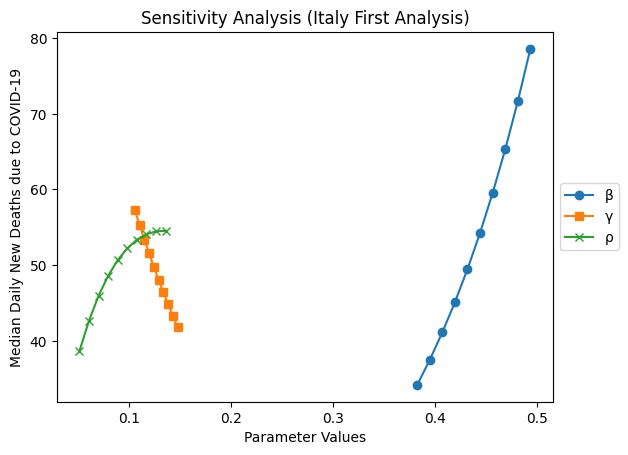

In [86]:
sensitivityAnalysis(trace,"Italy First Analysis",59110000)

In [20]:
trace = runAnalysis("Italy","second",0.449,0.0771)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.28883,0.03079,0.23578,0.34667,0.00084,0.00060,1393.32966,1882.35335,1.00099
γ,0.12635,0.01280,0.10387,0.15089,0.00026,0.00018,2438.13932,2652.64662,0.99992
ρ,0.08984,0.02699,0.04499,0.14110,0.00073,0.00052,1430.57177,1851.60910,1.00188
σ,85.10176,22.40413,47.97736,124.61407,0.43778,0.32241,2778.72601,2657.00481,1.00364
R0,1.34220,0.06789,1.21630,1.46541,0.00118,0.00084,3329.62897,3331.09617,1.00052
i0,3839.25427,1230.04018,1715.16620,6092.85109,32.39903,22.91421,1366.37024,1817.00289,1.00141


94% CI: [1.22, 1.48]


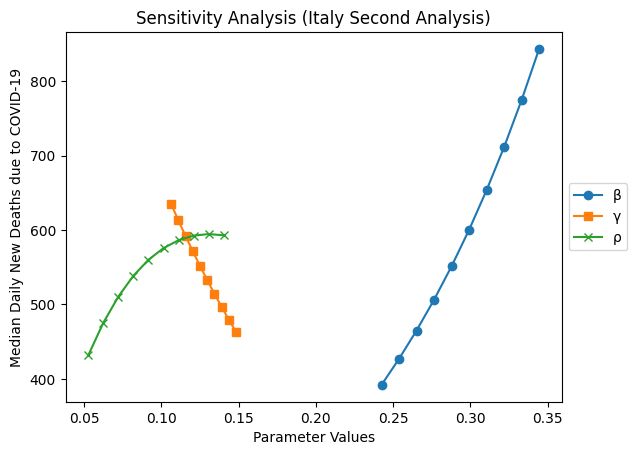

In [88]:
sensitivityAnalysis(trace,"Italy Second Analysis",59110000)

In [19]:
trace = runAnalysis("Italy","third",0.449,0.0771)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.19447,0.03190,0.13673,0.25484,0.00094,0.00066,1146.09189,1664.90071,1.00613
γ,0.12797,0.01255,0.10391,0.15084,0.00024,0.00017,2729.66208,2373.40306,1.00104
ρ,0.09832,0.02949,0.04833,0.15361,0.00087,0.00062,1124.05796,1630.40062,1.00572
σ,51.69152,13.24374,29.45541,76.16552,0.26259,0.19114,2703.63230,2500.25208,0.99996
R0,0.85666,0.03236,0.79516,0.91592,0.00075,0.00053,1908.70998,2332.24883,1.00327
i0,9216.42929,2862.34103,4745.30185,14923.95149,86.16352,60.94292,1116.45331,1571.39398,1.00588


94% CI: [0.79, 0.91]


#### Spain

In [95]:
trace = runAnalysis("Spain","first",0.360,0.0371)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.40769,0.02339,0.36542,0.45256,0.00060,0.00043,1509.75971,2126.78799,1.00478
γ,0.12582,0.01278,0.10202,0.14883,0.00026,0.00019,2322.31043,2613.59469,1.00189
ρ,0.04203,0.01310,0.01931,0.06552,0.00031,0.00022,1774.58759,2029.11742,1.00222
σ,10.22259,2.48465,6.04749,14.76008,0.04853,0.03510,2732.35274,2735.96618,1.00109
R0,2.44519,0.17756,2.12493,2.78335,0.00335,0.00237,2839.83640,2993.69172,1.00127
i0,187.92828,70.23959,70.02830,314.34195,1.80492,1.27652,1487.05824,2106.85038,1.00406


94% CI: [2.13, 2.80]


In [96]:
trace = runAnalysis("Spain","second",0.360,0.0371)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.21477,0.01990,0.17713,0.25164,0.00046,0.00033,1896.65403,2070.10595,1.00234
γ,0.12649,0.01265,0.10246,0.14974,0.00026,0.00018,2437.31791,2129.60852,1.00225
ρ,0.04308,0.01341,0.02112,0.06851,0.00033,0.00024,1537.42976,1965.56222,1.00558
σ,95.81618,24.43395,55.14128,139.30907,0.51668,0.37768,2311.92041,2306.05010,1.00130
R0,1.26973,0.06345,1.14815,1.38518,0.00094,0.00067,4710.52415,3369.87365,1.00014
i0,13304.19985,4440.14157,6099.81497,21329.49367,117.00785,84.49139,1500.89586,1827.22312,1.00535


94% CI: [1.16, 1.40]


#### UK

In [98]:
trace = runAnalysis("UK","first",0.373,0.0429)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 48 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.37424,0.02023,0.33716,0.41175,0.00049,0.00035,1676.81697,2153.64096,1.00295
γ,0.12537,0.01262,0.10288,0.15002,0.00026,0.00018,2341.08069,2390.17917,1.00121
ρ,0.04851,0.01461,0.02414,0.07485,0.00035,0.00025,1683.64061,2338.12445,1.00358
σ,8.47691,2.30517,4.83022,12.87334,0.04787,0.03469,2463.81851,2380.71079,1.00014
R0,2.16656,0.13452,1.90958,2.41817,0.00297,0.00210,2047.32594,2796.52682,1.00288
i0,563.37591,178.02615,259.57305,882.10017,4.43126,3.13394,1613.12416,2174.89993,1.00148


94% CI: [1.92, 2.44]


In [99]:
trace = runAnalysis("UK","second",0.373,0.0429)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.22898,0.02085,0.18943,0.26550,0.00048,0.00034,1922.36837,2133.34522,1.00139
γ,0.12648,0.01288,0.10205,0.15063,0.00025,0.00018,2700.86895,2287.57395,1.00160
ρ,0.04953,0.01545,0.02348,0.07924,0.00036,0.00026,1829.30048,2153.31691,1.00011
σ,102.98551,25.55280,60.57450,150.04280,0.50736,0.37698,2829.88434,2498.82010,1.00245
R0,1.30490,0.05548,1.20839,1.41282,0.00093,0.00066,3665.42199,3194.13403,1.00183
i0,15775.08477,5176.05502,7612.72843,25244.79238,121.38062,86.23486,1804.80687,2154.11105,1.00062


94% CI: [1.21, 1.42]


### Second Lockdown

In [23]:
def runAnalysis_second_q(country, analysis, beta,rho,before=True):
    if (before):
        df = dataset[country]['data']

        # Get the population from the current country
        pop = dataset[country]['pop']

        # Get the start of the policy
        date = dataset[country]['sLock'][0]
        
        model = runMCMC(df,pop,minusTime(date,11),addTime(date,5),0,beta,rho)

        model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

        # Extract useful information
        model_table = model_table.loc[['β','γ','ρ',"i0","R0"]]

        model_table.to_csv('mcmc_data/' + country + '/sLock_before.csv')

        title = "result_graphs/"+country+"/second_q/first"


    else:
        df = dataset[country]['data']

        # Get the population from the current country
        pop = dataset[country]['pop']

        # Get the start of the policy
        date = dataset[country]['sLock'][0]

        
        model = runMCMC(df,pop,addTime(date,5),addTime(date,20),0,beta,rho)

        # Get the table with useful information from our MCMC model
        model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]

        # Extract useful information
        # Extract useful information
        model_table = model_table.loc[['β','γ','ρ',"i0","R0"]]

        # Store the table as a csv file, used for later analysis
        model_table.to_csv('mcmc_data/' + country + '/sLock_after.csv')

        title = "result_graphs/"+country+"/second_q/second"

    # Display results of MCMC
    display(printMCMCTables(model[0]))

    # Plot Trace Plot
    plotMCMC(model[0],title+"_traceplot")

    # Run Posterior Predictive Sampling
    with model[1]:
        ppc = pm.sample_posterior_predictive(model[0], var_names=["obs",'β','γ','ρ',"i0"])

    print(model[2])
    _, ax = plt.subplots()
    days = np.linspace(0,len(ppc["obs"][0]), len(ppc["obs"][0]))
    sampled_obs = np.asarray(ppc['obs'])
    for i, item in enumerate(sampled_obs):
        ax.plot(days, np.absolute(item), "o", ms=4, alpha=0.4, label="New Deaths Predictions (Per Day)" if i == 0 else "")
    sampled_obs = np.absolute(sampled_obs)
    ax.plot(days,sampled_obs.mean(0), ms=4, alpha=1,label="Average New Deaths Predictions (Per Day)")
    ax.plot(days,model[2], ms=4, alpha=1, label="New Deaths Observed (Per Day)")
    ax.set_ylabel(r"Deaths due to COVID-19 (Unit)")
    ax.set_xlabel("Time after start of observation (Days)")
    ax.set_title("Posterior Predictive Sample " + country + " " + analysis + " analysis")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(title+'_pps.png',  bbox_inches='tight')
    plt.close()

    # Get the R0 from the posterior
    param_samples = model[0].posterior.R0

    # Calculate the 94% credible interval for the parameter
    ci = np.percentile(param_samples, [3, 97])
    print(f"94% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")

    return model

#### Netherlands

In [25]:
runAnalysis_second_q("Netherlands","first",0.300,0.00994)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 79 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.18087,0.03297,0.11393,0.23349,0.01059,0.00772,10.65242,30.02755,1.40139
γ,0.12630,0.01261,0.10372,0.15107,0.00031,0.00022,1694.45369,2022.95253,1.00672
ρ,0.01133,0.00342,0.00526,0.01739,0.00008,0.00006,1915.94722,2322.91345,1.00509
σ,18.12756,4.51350,10.62212,26.46340,0.10065,0.07169,2144.86605,2504.97627,1.00292
R0,1.31849,0.23358,0.88178,1.68835,0.07997,0.05860,10.01169,30.38380,1.43774
i0,3796.93277,1576.11808,1245.43407,6773.50058,298.02325,212.97175,29.53696,210.42218,1.12083


[39 25 17 71 66 61 64 53 29 34 86 78 75 84 54]
94% CI: [0.93, 1.75]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([39, 25, 17, 71, 66, 61, 64, 53, 29, 34, 86, 78, 75, 84, 54]),
 {'γ_log__': array([-2.2361004 , -2.08472454, -2.16415864, -2.08723452, -2.31633323,
         -2.09420145, -2.15272744, -2.14014506, -2.01326478, -2.07262562,
         -2.11737631, -2.08214242, -2.05800016, -2.03588355, -2.10011976,
         -1.90690059, -2.09487436, -2.08175565, -2.18956633, -2.08736326,
         -2.14115997, -2.24124524, -2.31256001, -2.08496518, -2.01709682,
         -2.10759076, -2.17029602, -2.1351007 , -2.10598773, -2.07603887,
         -2.29922876, -2.01145413, -2.11735731, -2.05984749, -1.9088405 ,
         -2.06015473, -2.02298515, -2.09808513, -2.00208397, -1.91694677,
         -1.95319982, -2.16252231, -2.13054275, -2.03975907, -2.01549014,
         -2.08242954, -2.07415472, -1.89325182, -2.20912404, -2.10124089,
         -2.0411847 , -2.03732839, -1.93929558, -2.08372703, -2.09838019,
       

In [26]:
runAnalysis_second_q("Netherlands","second",0.300,0.00994,False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 33 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9474050790000016, but should be close to 0.99. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.866432413430447, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.23051,0.13612,0.07767,0.51761,0.01369,0.00971,42.12710,149.23846,1.09033
γ,0.12669,0.01275,0.10222,0.14857,0.00040,0.00029,1026.94202,1245.21594,1.00693
ρ,0.01124,0.00345,0.00550,0.01771,0.00013,0.00009,675.50314,1063.35517,1.01642
σ,56.52983,24.78910,23.38334,102.87116,3.24941,2.30930,58.39137,867.91355,1.08025
R0,1.68876,1.02713,0.59306,3.92001,0.10501,0.07448,35.39007,175.86776,1.10209
i0,3580.19795,3677.64157,0.00110,9879.98275,522.11455,371.38310,53.93306,481.34882,1.08031


[ 28 114 104  89  98  46  28  44 170 112 108  97  36  47]
94% CI: [0.71, 4.45]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([ 28, 114, 104,  89,  98,  46,  28,  44, 170, 112, 108,  97,  36,
         47]),
 {'γ_log__': array([-2.14614762, -2.0522143 , -1.95407793, -2.00901615, -2.03760841,
         -2.11209116, -1.93515724, -1.99426551, -1.98484362, -1.91095721,
         -2.06814169, -2.0605095 , -1.96490765, -1.97042405, -2.10584851,
         -2.21682182, -2.03615499, -1.99917446, -2.04026251, -2.22971534,
         -2.0295657 , -1.91051291, -2.07569306, -1.93969465, -2.04003845,
         -1.95497756, -2.12090967, -1.96761272, -1.91588071, -2.2358579 ,
         -2.06100233, -1.97705333, -2.09725266, -2.0242969 , -2.23014785,
         -2.07737509, -2.06656413, -1.9075989 , -2.02597847, -2.08946091,
         -1.99479158, -2.0015069 , -2.09153219, -2.19335364, -2.18359894,
         -2.1883578 , -2.18108074, -1.91562067, -2.27203676, -2.06638746,
         -2.02522359, -2.13150754, -2.12676353, -2.15664566, -2

#### Italy

In [27]:
runAnalysis_second_q("Italy","first",0.343,0.02986326)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 70 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.13346,0.02506,0.08842,0.18034,0.00699,0.00524,14.10216,62.71960,1.26731
γ,0.12954,0.01315,0.10558,0.15417,0.00029,0.00020,2052.17250,2135.79584,1.00435
ρ,0.03646,0.01118,0.01654,0.05617,0.00027,0.00019,1569.03886,2108.47858,1.01072
σ,106.43195,27.18803,58.99313,155.33058,0.59644,0.43237,2253.76231,2270.26248,1.00408
R0,0.80411,0.13050,0.60717,1.03034,0.04814,0.03719,10.03620,27.50616,1.43943
i0,20846.72217,6787.23600,9469.46073,33450.52475,170.14452,120.33240,1554.05541,1491.96718,1.00550


[491 846 680 683 674 553 352 415 628 553 505 459 268 298 445]
94% CI: [0.60, 1.03]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([491, 846, 680, 683, 674, 553, 352, 415, 628, 553, 505, 459, 268,
        298, 445]),
 {'γ_log__': array([-2.23571504, -2.16095624, -2.1658795 , -1.8922539 , -2.06505188,
         -2.02334832, -1.97790509, -2.1325509 , -2.29112273, -2.35295975,
         -2.12491881, -1.990413  , -2.17623361, -2.23226205, -2.17407524,
         -2.03164809, -2.15505528, -1.96589905, -2.13104585, -2.11263546,
         -1.96515045, -1.93172672, -2.29025593, -2.06825305, -2.12771056,
         -1.99471432, -1.86214515, -2.02270297, -2.05945366, -1.95237695,
         -2.05120747, -2.28132493, -2.07628828, -2.24885264, -2.14658636,
         -1.96525913, -2.08722377, -2.14434597, -2.09201143, -2.00114129,
         -2.07472971, -2.2506091 , -2.01005632, -2.17199866, -1.9947033 ,
         -2.0514703 , -2.1525925 , -2.07162151, -2.18762716, -2.03524054,
         -2.11441555, -2.0384994 , -1.92136524, -2.1989472

In [28]:
runAnalysis_second_q("Italy","second",0.343,0.02986326,False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 33 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.17482,0.02228,0.13372,0.21623,0.00517,0.00372,17.52624,36.62774,1.21008
γ,0.12710,0.01247,0.10443,0.15144,0.00029,0.00021,1813.10238,1749.27007,1.00186
ρ,0.03515,0.01040,0.01863,0.05516,0.00027,0.00019,1501.18611,1546.84031,1.00263
σ,104.94335,26.08289,61.47463,153.64716,0.57013,0.40849,2189.10999,2308.47923,1.00161
R0,1.07909,0.10556,0.87146,1.27403,0.03385,0.02470,10.12329,27.36827,1.43738
i0,13604.37389,4329.15335,6059.23912,21287.83431,138.12810,97.70033,922.19321,1612.93401,1.02700


[575 555 462 364 347 348 649 548 414 620 483 361 448 616]
94% CI: [0.88, 1.29]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([575, 555, 462, 364, 347, 348, 649, 548, 414, 620, 483, 361, 448,
        616]),
 {'γ_log__': array([-2.13418684, -2.03148053, -2.29438902, -2.05055998, -1.98962384,
         -2.04758788, -1.97791657, -2.11088568, -2.17878205, -2.11862668,
         -2.0216307 , -2.10413785, -1.92846644, -2.01190035, -2.28226646,
         -1.95650054, -2.19489923, -2.1340088 , -2.09610882, -2.09348165,
         -2.19681952, -2.09427691, -2.10482912, -2.05654536, -2.09180254,
         -2.15559323, -2.17183349, -1.9451706 , -2.16226626, -1.97019028,
         -2.0339175 , -2.24369665, -2.17597898, -1.92944873, -1.90968425,
         -2.00504847, -1.86807275, -2.05189293, -2.10583176, -2.14839981,
         -2.05373442, -2.08850924, -2.17715606, -2.09056054, -2.06041267,
         -2.05797239, -1.89701821, -1.96669518, -2.03648326, -2.2813788 ,
         -2.20633895, -2.09718161, -1.94519349, -2.03771556, -2

#### Germany

In [29]:
runAnalysis_second_q("Germany","first",0.331,0.02440074)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.19699,0.01951,0.16159,0.23371,0.00044,0.00031,2006.35944,2214.83777,1.00111
γ,0.12654,0.01253,0.10485,0.15161,0.00024,0.00017,2625.52512,2445.26362,1.00038
ρ,0.02829,0.00856,0.01449,0.04484,0.00020,0.00014,2009.09134,2259.28031,1.00124
σ,45.15104,11.57692,25.51343,66.60939,0.22193,0.16404,2975.33010,2798.99077,1.00077
R0,1.27511,0.09044,1.10877,1.44556,0.00136,0.00098,4662.14172,3156.13837,1.00094
i0,6809.75619,2258.91867,2877.25922,10772.87257,51.25435,36.24774,1852.72793,1826.30814,1.00167


[199 123 125 243 237 247 269 261 194 169 279 331 318 340 253]
94% CI: [1.12, 1.46]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([199, 123, 125, 243, 237, 247, 269, 261, 194, 169, 279, 331, 318,
        340, 253]),
 {'γ_log__': array([-2.03409514, -2.05874255, -2.18949375, -2.24565897, -2.17494662,
         -2.20757161, -1.97860409, -2.00879525, -2.10394463, -1.98481559,
         -2.04728458, -2.01389667, -1.97812568, -2.05722492, -2.07494093,
         -1.94581991, -2.02712444, -1.99469887, -1.96247716, -2.20120558,
         -2.06932432, -2.06889247, -2.12028917, -2.11692496, -1.97721698,
         -2.21387498, -1.96778363, -2.0218561 , -2.13386198, -2.31907943,
         -2.06492541, -2.12530401, -1.97224307, -2.15136425, -2.08827847,
         -1.96970239, -2.12751936, -2.14376124, -2.10400413, -2.06262877,
         -2.09089255, -2.05370245, -1.94351998, -1.99512694, -2.11797193,
         -2.14211642, -2.18544984, -1.9175556 , -2.0358974 , -2.06203621,
         -2.02653708, -2.04369265, -1.99229285, -1.9687646

In [30]:
runAnalysis_second_q("Germany","second",0.331,0.02440074,False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 83 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9555757506453453, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.18233,0.02869,0.13204,0.23210,0.00975,0.00714,9.26012,142.18985,1.52346
γ,0.12781,0.01297,0.10368,0.15213,0.00046,0.00033,810.38531,921.94542,1.01187
ρ,0.02813,0.00823,0.01495,0.04334,0.00031,0.00022,786.38790,853.10147,1.00278
σ,74.88456,23.02842,37.72498,118.56365,0.71487,0.50620,1082.48471,1601.91695,1.00929
R0,1.17211,0.16785,0.94781,1.43909,0.06751,0.05019,7.86545,127.39036,1.69534
i0,12498.82415,3959.01053,5741.04355,19801.71914,391.33858,277.51061,94.51038,1068.71614,1.04502


[167 324 348 418 434 416 371 224 450 513 533 568 533 343]
94% CI: [0.96, 1.46]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([167, 324, 348, 418, 434, 416, 371, 224, 450, 513, 533, 568, 533,
        343]),
 {'γ_log__': array([-2.01722691, -2.02282964, -1.98334751, -2.14251551, -1.92675018,
         -2.06339534, -2.03993396, -2.31234929, -1.92307573, -2.13244488,
         -1.87068154, -1.97416527, -1.93344911, -2.04932817, -2.27656575,
         -2.13201859, -2.18327267, -2.11740783, -1.98863907, -1.90827812,
         -2.05986207, -2.07329797, -1.93671204, -1.9954296 , -2.00082228,
         -2.27045897, -2.22517389, -2.15953538, -2.03483391, -2.23563834,
         -2.07849062, -2.1567287 , -2.20834258, -1.84055273, -2.09984154,
         -2.19375142, -2.22730931, -1.91352581, -1.93509894, -1.94686457,
         -2.16393544, -2.13592352, -2.08381768, -2.10902285, -2.06919196,
         -2.14999909, -2.16419531, -1.99380914, -2.12752833, -2.04368219,
         -1.98221574, -2.11435811, -2.20358036, -2.07016462, -2

### Additional Analysis

In [34]:
def runAnalysis_sweden(country, beta, rho, before=True):
    if before:
        for x in range (0,18,3):
            df = dataset[country]['data']

            # Get the population from the current country
            pop = dataset[country]['pop']

            # Get the start of the policy
            date = dataset[country]['fLock'][0]
            
            model = runMCMC(df,pop,minusTime(date,11),addTime(date,(x+5)),0,beta,rho)

            model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
            model_table = model_table.loc[['β','γ','ρ','i0','R0']]
            model_table.to_csv('mcmc_data/' + country + '/analysis_'+str(x/3)+'.csv')

            # Display results of MCMC
            display(printMCMCTables(model[0]))

            # Run Posterior Predictive Check
            with model[1]:
                ppc = pm.sample_posterior_predictive(model[0], var_names=["obs"])

            # Plot Posterior Predictive Sampling 
            _, ax = plt.subplots()
            days = np.linspace(0,len(ppc["obs"][0]), len(ppc["obs"][0]))
            sampled_obs = np.asarray(ppc['obs'])
            for i, item in enumerate(sampled_obs):
                ax.plot(days, np.absolute(item), "o", ms=4, alpha=0.4, label="New Deaths\day Predictions" if i == 0 else "")
            sampled_obs = np.absolute(sampled_obs)
            ax.plot(days,sampled_obs.mean(0), ms=4, alpha=1,label="Average new Deaths\day Prediction")
            ax.plot(days,model[2], ms=4, alpha=1, label="Observed new Deaths Values")
            ax.set_ylabel(r"Death\unit due to COVID-19")
            ax.set_xlabel("time\days after start of observation")
            ax.set_title("Posterior Predictive Sample")
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.savefig("result_graphs/"+country+"/extended_analysis/additive_analysis_"+str(x/3)+'_pps.png',  bbox_inches='tight')
            plt.close()

            # Get the R0 from the posterior
            param_samples = model[0].posterior.R0

            # Calculate the 94% credible interval for the parameter
            ci = np.percentile(param_samples, [3, 97])
            print(f"94% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")
    else:
            df = dataset[country]['data']

            # Get the population from the current country
            pop = dataset[country]['pop']

            # Get the start of the policy
            date = dataset[country]['fLock'][0]
            newDate = minusTime(date,11)
            for x in range (0,18,3):
                    
                    model = runMCMC(df,pop,addTime(newDate,x),addTime(newDate,(x+15)),0,beta,rho)

                    model_table = printMCMCTables(model[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
                    model_table = model_table.loc[['β','γ','ρ','i0','R0']]
                    model_table.to_csv('mcmc_data/' + country + '/analysis_'+str(x/3)+'_second_version.csv')

                    # Display results of MCMC
                    display(printMCMCTables(model[0]))

                    # Run Posterior Predictive Check
                    with model[1]:
                        ppc = pm.sample_posterior_predictive(model[0], var_names=["obs"])

                    # Plot Posterior Predictive Sampling 
                    _, ax = plt.subplots()
                    days = np.linspace(0,len(ppc["obs"][0]), len(ppc["obs"][0]))
                    sampled_obs = np.asarray(ppc['obs'])
                    for i, item in enumerate(sampled_obs):
                        ax.plot(days, np.absolute(item), "o", ms=4, alpha=0.4, label="New Deaths\day Predictions" if i == 0 else "")
                    sampled_obs = np.absolute(sampled_obs)
                    ax.plot(days,sampled_obs.mean(0), ms=4, alpha=1,label="Average new Deaths\day Prediction")
                    ax.plot(days,model[2], ms=4, alpha=1, label="Observed new Deaths Values")
                    ax.set_ylabel(r"Death\unit due to COVID-19")
                    ax.set_xlabel("time\days after start of observation")
                    ax.set_title("Posterior Predictive Sample")
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.savefig("result_graphs/"+country+"/extended_analysis/rolling_analysis_"+str(x/3)+'_pps.png',  bbox_inches='tight')
                    plt.close()

                    # Get the R0 from the posterior
                    param_samples = model[0].posterior.R0

                    # Calculate the 94% credible interval for the parameter
                    ci = np.percentile(param_samples, [3, 97])
                    print(f"94% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")


    return model

In [35]:
runAnalysis_sweden("Sweden",0.132,0.0070)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 35 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.46533,0.03939,0.39210,0.53561,0.00097,0.00070,1846.67718,1614.12449,1.00200
γ,0.12316,0.01221,0.10140,0.14679,0.00020,0.00014,3653.47069,3029.91230,1.00291
ρ,0.00791,0.00250,0.00361,0.01237,0.00004,0.00003,3333.92779,3067.64182,1.00132
σ,0.54695,0.16409,0.27759,0.85229,0.00340,0.00244,2543.41520,2696.43407,1.00040
R0,3.57377,0.38342,2.88822,4.29203,0.00755,0.00550,2893.57919,2025.39382,1.00228
i0,9.84684,5.89254,0.91114,20.47391,0.12616,0.08922,1932.10168,1641.48403,1.00087


94% CI: [2.95, 4.41]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.36045,0.03255,0.30313,0.42391,0.00087,0.00063,1528.28675,1131.93917,1.00156
γ,0.12349,0.01224,0.10075,0.14600,0.00022,0.00016,3102.97517,2990.58828,1.00069
ρ,0.00788,0.00244,0.00386,0.01248,0.00006,0.00004,1779.62092,2562.95917,1.00340
σ,1.01506,0.25911,0.57984,1.48549,0.00543,0.00393,2432.94951,2701.24959,1.00173
R0,2.75965,0.28895,2.28398,3.32397,0.00632,0.00478,2734.77984,1863.34497,1.00123
i0,32.76314,18.51914,5.39185,67.64629,0.49319,0.34881,1171.35715,1315.44598,1.00183


94% CI: [2.30, 3.36]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.37606,0.02045,0.33470,0.41265,0.00045,0.00032,2063.64607,2421.92569,1.00350
γ,0.12383,0.01253,0.10031,0.14679,0.00025,0.00018,2506.93542,2834.81687,1.00111
ρ,0.00784,0.00239,0.00371,0.01215,0.00005,0.00003,2542.13141,2400.74614,1.00023
σ,1.13533,0.25125,0.71053,1.60818,0.00475,0.00343,2879.39163,2818.19311,1.00099
R0,2.87328,0.21726,2.47757,3.27690,0.00365,0.00260,3604.06335,3302.91338,1.00024
i0,26.13800,11.51661,8.42225,46.57554,0.26917,0.19036,1828.10237,1924.41519,1.00186


94% CI: [2.51, 3.32]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.32027,0.01764,0.28877,0.35355,0.00042,0.00029,1778.78101,2289.67528,1.00176
γ,0.12356,0.01207,0.10103,0.14620,0.00028,0.00020,1956.51271,2792.11893,1.00019
ρ,0.00788,0.00242,0.00366,0.01232,0.00005,0.00003,2426.76429,2750.28014,1.00098
σ,1.80100,0.36598,1.18807,2.49389,0.00672,0.00485,3059.07118,2704.09286,1.00190
R0,2.44917,0.16468,2.14369,2.75210,0.00280,0.00198,3368.35061,3468.63893,1.00097
i0,67.93176,27.42888,23.50094,118.36355,0.61007,0.43642,2044.87155,2272.33447,1.00177


94% CI: [2.16, 2.78]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.28854,0.01521,0.25955,0.31575,0.00034,0.00024,2007.63062,2513.43507,1.00003
γ,0.12359,0.01187,0.10074,0.14517,0.00026,0.00018,2153.91880,2618.66234,1.00195
ρ,0.00795,0.00240,0.00388,0.01244,0.00005,0.00004,2376.60940,2413.84344,1.00132
σ,2.57190,0.48916,1.66570,3.44875,0.00942,0.00677,2746.00639,2788.36327,1.00170
R0,2.20379,0.13424,1.95520,2.45562,0.00238,0.00169,3128.42782,3481.76770,1.00043
i0,122.03920,45.80000,48.42385,208.09105,0.99819,0.70592,2061.16877,2298.71969,1.00143


94% CI: [1.97, 2.47]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 42 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.28190,0.01436,0.25369,0.30763,0.00032,0.00023,1964.98617,2142.14387,1.00671
γ,0.12346,0.01233,0.10135,0.14641,0.00027,0.00019,2032.74812,2462.95677,1.00325
ρ,0.00794,0.00239,0.00397,0.01244,0.00005,0.00003,2541.93838,2735.92734,1.00134
σ,2.87429,0.54182,1.98968,3.93641,0.01082,0.00808,2770.63017,2187.45476,1.00140
R0,2.15590,0.12419,1.92445,2.38022,0.00242,0.00171,2636.98448,2727.43085,1.00154
i0,142.27815,51.03676,60.30447,236.56677,1.04057,0.73609,2396.30110,2677.17594,1.00133


94% CI: [1.94, 2.40]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([ 0,  0,  0,  0,  0,  1,  0,  1,  1,  2,  2,  1,  6,  7,  9,  8, 11,
        11, 21, 22, 31, 32, 35, 38, 45, 48, 53, 70, 80, 70]),
 {'γ_log__': array([-2.22837942, -2.1051562 , -1.97545419, -1.92081231, -2.06915502,
         -2.11954233, -1.96436313, -1.95106239, -2.04664173, -2.04576483,
         -2.34681012, -2.18570616, -1.97160533, -2.05421261, -2.13664087,
         -2.17291697, -2.12742629, -2.12348971, -2.11052588, -2.10327634,
         -2.11322433, -1.9097722 , -2.11887148, -2.04195361, -1.88758709,
         -2.05629178, -2.08690623, -1.99875689, -2.01555428, -2.14363842,
         -2.00262398, -1.98532859, -2.0296387 , -2.0812059 , -2.04462917,
         -2.07062196, -2.22134037, -1.96941807, -2.00495023, -1.96618677,
         -2.07878185, -2.24424683, -2.19529147, -1.89338711, -2.23471528,
         -1.92928853, -2.23424684, -2.26994171, -2.29981597, -2.01214774,
         -2.1

In [36]:
runAnalysis_sweden("Sweden",0.132,0.0070,False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 31 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.49662,0.04884,0.41273,0.59288,0.00102,0.00073,2411.43459,2207.84577,1.00138
γ,0.12349,0.01231,0.10025,0.14544,0.00020,0.00014,3691.46318,2951.69029,1.00077
ρ,0.00785,0.00245,0.00383,0.01236,0.00004,0.00003,3362.54993,2539.05441,1.00177
σ,0.52275,0.16083,0.25090,0.81264,0.00307,0.00226,2996.76602,2530.73948,1.00168
R0,3.80674,0.45273,2.99034,4.67430,0.00840,0.00610,3106.95557,2106.35165,1.00158
i0,7.11896,5.02120,0.63779,15.77435,0.09970,0.07096,2319.24594,2214.53110,1.00134


94% CI: [3.05, 4.75]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.37801,0.03849,0.31087,0.44997,0.00091,0.00067,1931.56898,1658.92847,1.00368
γ,0.12361,0.01243,0.10027,0.14611,0.00022,0.00016,3197.00785,3107.28184,1.00103
ρ,0.00784,0.00234,0.00403,0.01226,0.00004,0.00003,2828.19041,2951.48087,1.00091
σ,1.05365,0.29961,0.53850,1.57505,0.00606,0.00452,2673.02259,2630.44816,1.00092
R0,2.89399,0.34465,2.30251,3.55971,0.00715,0.00528,2805.80228,1959.66292,1.00259
i0,55.57841,29.37847,8.25390,108.28073,0.60197,0.42571,2010.08936,1545.61002,1.00159


94% CI: [2.35, 3.64]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.35631,0.02716,0.30583,0.40748,0.00061,0.00043,2099.13621,2131.42748,1.00116
γ,0.12383,0.01235,0.10133,0.14670,0.00025,0.00018,2501.74980,2577.81790,1.00077
ρ,0.00781,0.00236,0.00380,0.01214,0.00005,0.00003,2594.45767,2667.27310,1.00075
σ,1.53720,0.41850,0.86215,2.35297,0.00808,0.00599,2957.94599,2486.54128,1.00084
R0,2.72254,0.25002,2.26002,3.18915,0.00442,0.00316,3294.50034,2718.96266,1.00179
i0,141.59841,59.75585,44.89027,255.07890,1.33384,0.94605,1983.15416,2194.79838,1.00026


94% CI: [2.30, 3.25]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.31961,0.01919,0.28560,0.35837,0.00042,0.00030,2095.88256,2624.70848,1.00111
γ,0.12404,0.01179,0.10190,0.14611,0.00025,0.00017,2279.43919,2810.60556,1.00177
ρ,0.00792,0.00243,0.00383,0.01257,0.00006,0.00004,1484.90446,2442.21385,1.00116
σ,2.18182,0.58481,1.21010,3.25683,0.01110,0.00802,2956.19713,2784.41056,1.00064
R0,2.43444,0.18261,2.10989,2.78980,0.00303,0.00216,3756.63553,2937.81642,1.00093
i0,391.69733,142.39543,151.61195,643.65749,3.78537,2.67721,1387.88278,2313.17914,1.00098


94% CI: [2.12, 2.81]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 31 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.27355,0.01657,0.24346,0.30573,0.00033,0.00024,2457.37696,2706.92525,1.00156
γ,0.12338,0.01216,0.10176,0.14737,0.00024,0.00017,2478.32697,2886.02099,1.00161
ρ,0.00788,0.00234,0.00398,0.01246,0.00005,0.00003,2225.90445,2301.13998,1.00126
σ,2.76681,0.72861,1.60017,4.15854,0.01482,0.01048,2456.26746,2712.44934,1.00076
R0,2.09373,0.13471,1.84360,2.33777,0.00217,0.00154,3944.65894,3393.09301,1.00074
i0,993.06196,322.10511,471.27724,1618.41567,6.89644,4.93432,2238.79325,2260.12436,1.00155


94% CI: [1.86, 2.36]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 40 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.26674,0.01484,0.23903,0.29503,0.00032,0.00023,2134.55608,2541.96326,1.00339
γ,0.12389,0.01217,0.10218,0.14680,0.00025,0.00018,2308.25860,2611.37628,1.00075
ρ,0.00786,0.00242,0.00382,0.01232,0.00005,0.00004,2195.10046,2342.70275,1.00357
σ,3.22464,0.83899,1.86621,4.82275,0.01697,0.01231,2560.24190,2598.62781,1.00120
R0,2.03374,0.11708,1.80920,2.24529,0.00206,0.00147,3279.43622,3319.17509,1.00115
i0,1676.64117,554.60557,778.61351,2657.05092,12.07956,8.71735,2157.40545,2349.12452,1.00420


94% CI: [1.83, 2.27]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([ 8, 11, 11, 21, 22, 31, 32, 35, 38, 45, 48, 53, 70, 80]),
 {'γ_log__': array([-1.98452707, -2.04032949, -2.05220488, -2.07652527, -2.15997541,
         -2.14148564, -2.37678098, -1.99864162, -2.25528069, -1.96467801,
         -2.08393963, -2.07850544, -2.13949126, -2.20725136, -2.1609463 ,
         -2.11441105, -2.12677594, -2.13772794, -2.02412052, -2.11842443,
         -2.148943  , -1.84712099, -2.27493398, -1.92630642, -1.97380666,
         -2.0403654 , -2.13305668, -2.02958457, -2.21681246, -2.16746955,
         -2.19674822, -2.10281185, -2.16431133, -2.19590471, -1.98731668,
         -1.89364191, -1.96593112, -2.00884791, -2.15303871, -2.08846117,
         -2.10280234, -2.27101585, -2.10414543, -1.9436557 , -2.09633389,
         -2.10224749, -2.1747518 , -1.90273174, -2.09721361, -2.22674148,
         -1.96518531, -2.04902046, -2.07926823, -1.95282406, -2.09968908,
         -2

In [37]:
runAnalysis_sweden("Switzerland",0.310,0.0147)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.38959,0.04247,0.31673,0.47578,0.00112,0.00081,1539.88544,1452.83061,1.00674
γ,0.12469,0.01259,0.10163,0.14828,0.00023,0.00016,3078.21415,2918.38395,1.00198
ρ,0.01680,0.00525,0.00795,0.02638,0.00011,0.00008,2393.88019,2905.86374,1.00014
σ,1.86062,0.50515,0.99509,2.79121,0.00971,0.00698,2828.19560,2878.40764,1.00204
R0,2.76995,0.33447,2.18279,3.40527,0.00704,0.00511,2428.08519,2072.32493,1.00360
i0,36.89006,22.37980,3.09919,76.06832,0.55297,0.39108,1510.04561,1633.61367,1.00564


94% CI: [2.23, 3.48]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 22 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.31647,0.03123,0.26088,0.37618,0.00063,0.00045,2466.08587,2901.38563,1.00102
γ,0.12496,0.01266,0.10177,0.14857,0.00021,0.00015,3484.77212,3258.20397,1.00116
ρ,0.01681,0.00506,0.00843,0.02645,0.00009,0.00007,2971.40771,2922.61647,1.00061
σ,2.74811,0.69163,1.58914,4.06839,0.01312,0.00976,3125.91257,2591.94522,1.00118
R0,2.24369,0.23435,1.82766,2.67646,0.00412,0.00296,3415.05174,3041.18158,1.00188
i0,80.97107,40.56064,20.02424,157.43692,0.81423,0.57581,2351.01275,2380.08799,1.00087


94% CI: [1.87, 2.73]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.30917,0.02296,0.26642,0.35269,0.00052,0.00037,1982.16734,2455.40414,1.00204
γ,0.12531,0.01218,0.10279,0.14812,0.00023,0.00016,2825.18262,2770.13907,1.00132
ρ,0.01672,0.00513,0.00839,0.02653,0.00010,0.00007,2386.04197,2708.51424,1.00142
σ,3.24617,0.71633,2.01983,4.59198,0.01331,0.00945,2898.70511,2950.81874,1.00079
R0,2.18723,0.17389,1.86713,2.51204,0.00274,0.00194,3981.18046,3528.67890,1.00058
i0,93.27368,43.07983,25.22371,173.20289,0.99467,0.70345,1852.59042,2210.89984,1.00245


94% CI: [1.89, 2.55]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.28540,0.01773,0.25039,0.31679,0.00039,0.00027,2086.15850,1984.13330,1.00320
γ,0.12515,0.01285,0.10252,0.14991,0.00025,0.00018,2546.60526,2856.52336,1.00139
ρ,0.01682,0.00516,0.00846,0.02658,0.00011,0.00008,2065.63137,2655.87895,1.00258
σ,3.83147,0.78385,2.46655,5.29545,0.01528,0.01103,2709.81724,2709.24512,1.00166
R0,2.02020,0.12980,1.78809,2.26787,0.00214,0.00153,3811.79078,3349.23968,1.00164
i0,128.92262,51.73235,43.89888,221.55342,1.20628,0.86435,1848.95321,2157.46558,1.00345


94% CI: [1.80, 2.28]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.25878,0.01601,0.22901,0.28832,0.00035,0.00025,2060.15582,2334.86093,1.00033
γ,0.12549,0.01237,0.10392,0.15083,0.00024,0.00017,2586.64311,2432.81387,1.00061
ρ,0.01659,0.00502,0.00846,0.02646,0.00010,0.00007,2298.56221,2319.92744,1.00231
σ,4.89731,0.90146,3.26387,6.62493,0.01697,0.01221,2893.72834,2624.44343,1.00110
R0,1.82861,0.10232,1.63960,2.01740,0.00158,0.00112,4238.46430,3289.23431,0.99978
i0,205.22083,77.77245,88.83278,358.06114,1.78363,1.27484,1995.88999,2197.01623,1.00146


94% CI: [1.65, 2.03]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 29 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.23748,0.01702,0.20615,0.26957,0.00039,0.00028,1864.75094,2243.53034,1.00176
γ,0.12610,0.01313,0.10285,0.15128,0.00028,0.00020,2128.62277,2259.68066,1.00158
ρ,0.01692,0.00526,0.00827,0.02711,0.00012,0.00009,2036.12012,2492.90820,1.00065
σ,6.90214,1.21809,4.68705,9.10083,0.02235,0.01596,3012.63500,2746.31401,1.00106
R0,1.66685,0.09208,1.50736,1.84887,0.00148,0.00106,4089.11355,2711.79908,1.00090
i0,302.54258,119.07420,113.50584,518.97394,2.77014,1.95909,1651.44776,2237.40481,1.00131


94% CI: [1.51, 1.85]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([ 0,  1,  0,  3,  2,  3,  1,  3,  8, 11,  7,  8, 10, 20, 20, 15, 28,
        20, 35, 42, 35, 56, 47, 58, 51, 61, 59, 55, 59, 52]),
 {'γ_log__': array([-1.97725006, -2.05119618, -2.32260859, -2.12109208, -2.21812127,
         -1.99844412, -2.06541857, -2.23325184, -2.11504444, -2.10094496,
         -2.10398915, -2.05820438, -2.03220935, -2.12221621, -1.9816637 ,
         -1.94693623, -2.2452765 , -2.03715453, -1.99708599, -1.95478606,
         -1.95985275, -1.94756999, -2.10764883, -2.05618553, -2.19781189,
         -2.03359737, -2.15243393, -2.04441086, -2.0424259 , -2.02097541,
         -2.02954948, -2.01862686, -1.9970171 , -2.21095836, -2.14843355,
         -2.10031684, -2.01479558, -2.23927994, -2.08277705, -2.07130341,
         -2.2695433 , -2.06338971, -2.05138597, -2.17534627, -1.93099183,
         -2.04597161, -2.22085001, -2.07036782, -2.11220883, -2.13325407,
         -1.9

In [38]:
runAnalysis_sweden("Switzerland",0.310,0.01473366, False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 35 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.41720,0.06944,0.29971,0.55440,0.00149,0.00108,2349.97265,2293.41253,1.00254
γ,0.12445,0.01252,0.10229,0.14904,0.00023,0.00016,2940.78242,3040.17782,1.00218
ρ,0.01679,0.00521,0.00852,0.02694,0.00010,0.00007,2848.17417,2752.97672,1.00181
σ,1.91474,0.55070,1.00637,2.90556,0.01112,0.00871,3006.23007,2370.33926,1.00085
R0,2.97341,0.53178,2.04644,4.00201,0.01060,0.00776,2793.96510,2321.55384,1.00077
i0,30.88587,24.40927,0.42026,72.67298,0.47915,0.33885,2304.95810,2149.81847,1.00207


94% CI: [2.16, 4.18]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.33969,0.03293,0.28083,0.40344,0.00088,0.00064,1588.55383,1564.35101,1.00179
γ,0.12512,0.01236,0.10141,0.14764,0.00022,0.00016,3348.92446,3093.07305,1.00058
ρ,0.01675,0.00514,0.00843,0.02661,0.00010,0.00007,2591.63294,2865.29859,1.00234
σ,2.62663,0.74385,1.38492,4.00142,0.01548,0.01206,2687.92347,2395.03099,1.00143
R0,2.40682,0.25552,1.93386,2.85255,0.00488,0.00362,3290.11306,2637.21580,1.00042
i0,117.31653,54.25435,33.71969,220.92273,1.22369,0.86541,1609.59099,1624.69180,1.00305


94% CI: [1.98, 2.91]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.31515,0.02819,0.26647,0.36763,0.00068,0.00048,1853.49044,2209.96644,1.00245
γ,0.12498,0.01253,0.10159,0.14832,0.00024,0.00017,2697.06262,2998.38919,1.00013
ρ,0.01669,0.00515,0.00808,0.02634,0.00011,0.00008,2145.71490,2869.60384,1.00342
σ,3.59099,1.00333,1.94795,5.41025,0.02120,0.01575,2606.52048,2149.45476,1.00135
R0,2.23599,0.21825,1.88555,2.61574,0.00432,0.00326,3474.16602,2495.38000,1.00063
i0,247.42631,101.56754,86.98377,442.44390,2.51561,1.77913,1448.55619,1970.76852,1.00508


94% CI: [1.91, 2.64]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 23 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.27690,0.02421,0.23034,0.32220,0.00050,0.00035,2367.62231,2682.94823,1.00139
γ,0.12519,0.01262,0.10229,0.14911,0.00024,0.00017,2695.56272,2928.15910,1.00080
ρ,0.01669,0.00509,0.00858,0.02656,0.00010,0.00007,2585.03249,2631.00215,1.00318
σ,5.14140,1.28082,3.07532,7.51516,0.02398,0.01770,3103.70235,2569.98457,1.00076
R0,1.96027,0.17146,1.65022,2.27336,0.00260,0.00188,4708.87205,3538.22260,1.00068
i0,548.24886,202.25331,220.73417,930.41696,4.27383,3.02245,2196.29495,2434.86476,1.00243


94% CI: [1.68, 2.32]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.24291,0.01892,0.20752,0.27777,0.00042,0.00030,2051.40969,2545.75725,1.00175
γ,0.12564,0.01261,0.10316,0.14993,0.00026,0.00018,2496.56665,2259.87369,1.00139
ρ,0.01692,0.00530,0.00795,0.02668,0.00014,0.00010,1429.18132,2051.03107,1.00110
σ,5.78367,1.54589,3.25595,8.55524,0.02987,0.02159,2861.89163,2969.22300,1.00062
R0,1.71037,0.11835,1.49029,1.92631,0.00167,0.00120,5331.41019,3204.47857,1.00247
i0,1038.62953,362.39482,437.15155,1687.16503,9.28410,6.56610,1370.76526,1960.11333,1.00145


94% CI: [1.51, 1.95]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.20723,0.01846,0.17370,0.24274,0.00040,0.00028,2156.62128,2653.10372,1.00140
γ,0.12568,0.01259,0.10210,0.14876,0.00026,0.00019,2296.86836,2141.58307,1.00180
ρ,0.01703,0.00536,0.00847,0.02720,0.00012,0.00009,1857.14068,2372.66346,1.00202
σ,7.11093,1.84881,4.06953,10.56867,0.03468,0.02499,2954.03928,3144.83303,1.00006
R0,1.45631,0.10038,1.27784,1.65303,0.00147,0.00106,4920.00705,3251.57738,1.00090
i0,1767.65931,600.88411,830.46944,2938.72085,14.18632,10.03287,1773.14920,2323.49175,1.00235


94% CI: [1.29, 1.67]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([15, 28, 20, 35, 42, 35, 56, 47, 58, 51, 61, 59, 55, 59]),
 {'γ_log__': array([-2.06453791, -2.07017259, -2.04048113, -2.05242145, -1.95638167,
         -2.08296434, -2.08467043, -2.02407252, -2.05783011, -2.07495046,
         -2.07213763, -2.18831613, -2.17232146, -2.10187523, -2.07619485,
         -2.01941283, -2.05596554, -2.12346124, -1.98877266, -2.03579891,
         -2.10270596, -2.04979037, -2.02468761, -2.1416642 , -2.20467807,
         -2.10288286, -2.11302693, -2.07447393, -2.12036926, -2.3249736 ,
         -1.98519472, -1.99887376, -2.07655584, -2.17329703, -1.87615376,
         -2.13397321, -1.9363456 , -2.02685217, -2.12311388, -2.11106663,
         -2.04481526, -2.16829151, -2.28204557, -1.99405242, -2.04078942,
         -2.13854233, -1.95416066, -2.16191759, -1.99917052, -2.00241503,
         -2.05543759, -2.14671684, -2.09395628, -2.08258502, -1.94028388,
         -2

In [39]:
runAnalysis_sweden("Italy",0.449,0.0771)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.43394,0.03510,0.36658,0.49868,0.00091,0.00064,1515.91624,1971.87249,1.00008
γ,0.12559,0.01243,0.10290,0.14830,0.00023,0.00016,2982.33052,2964.12179,1.00139
ρ,0.08668,0.02672,0.04022,0.13350,0.00066,0.00047,1692.04437,2243.59187,1.00156
σ,15.26017,4.72568,7.13986,23.59412,0.10104,0.07181,2187.58688,2509.66542,1.00213
R0,2.06339,0.17065,1.75461,2.38462,0.00309,0.00219,3033.47768,3344.97791,1.00012
i0,121.35326,50.33104,41.20894,213.51401,1.29278,0.91431,1480.19587,1799.73618,1.00107


94% CI: [1.77, 2.41]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.39627,0.03426,0.33413,0.46164,0.00091,0.00064,1427.96237,1690.58065,1.00254
γ,0.12567,0.01288,0.10288,0.14978,0.00026,0.00018,2597.65064,2552.95252,1.00114
ρ,0.08697,0.02588,0.04037,0.13264,0.00062,0.00044,1747.00013,2129.25839,1.00262
σ,27.08614,6.72916,15.58434,39.51550,0.13392,0.09502,2589.08884,2892.72448,1.00179
R0,1.87865,0.14411,1.62816,2.15528,0.00251,0.00178,3231.26491,3028.15328,1.00233
i0,191.94393,81.99487,62.96466,340.14981,2.09350,1.50627,1547.48765,1989.71547,1.00141


94% CI: [1.63, 2.16]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.36232,0.03265,0.30066,0.41995,0.00086,0.00061,1422.37585,2175.77781,1.00361
γ,0.12546,0.01276,0.10331,0.15094,0.00026,0.00019,2438.52006,2508.51818,1.00248
ρ,0.08762,0.02626,0.04183,0.13402,0.00062,0.00044,1797.64144,2544.32399,1.00263
σ,36.40550,7.69412,23.28479,50.55975,0.14873,0.10936,2872.23667,2738.99396,1.00268
R0,1.71275,0.11435,1.50676,1.93169,0.00203,0.00144,3175.66255,3069.16340,1.00020
i0,289.17988,116.75025,114.80882,517.87710,2.91687,2.06291,1590.89315,2206.68401,1.00487


94% CI: [1.51, 1.94]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.36277,0.03160,0.30639,0.42020,0.00090,0.00064,1308.24362,1709.02005,1.00562
γ,0.12531,0.01267,0.10309,0.15009,0.00026,0.00018,2468.44959,2814.36174,1.00055
ρ,0.08821,0.02684,0.04288,0.13691,0.00073,0.00054,1457.91687,2052.68652,1.00406
σ,41.75075,8.37005,27.01789,57.32278,0.15921,0.11367,2792.71606,2895.93451,0.99978
R0,1.71133,0.11002,1.50778,1.92197,0.00223,0.00158,2423.70164,2652.78282,1.00205
i0,293.14217,112.68010,120.14403,510.62528,2.93016,2.07235,1396.57333,2094.59572,1.00375


94% CI: [1.52, 1.93]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.32744,0.03123,0.27212,0.38604,0.00101,0.00072,961.49527,1563.53871,1.00420
γ,0.12595,0.01289,0.10161,0.15051,0.00026,0.00019,2475.18844,2504.49834,1.00354
ρ,0.08947,0.02775,0.04160,0.14079,0.00089,0.00063,1010.34937,2001.41510,1.00295
σ,59.48448,10.99835,39.69127,79.75372,0.20709,0.14809,2869.88711,2458.71512,1.00183
R0,1.53001,0.08398,1.37955,1.69107,0.00196,0.00139,1855.00948,2842.17535,1.00212
i0,520.28306,190.84684,203.16628,873.13454,5.49947,3.88966,1066.42315,1870.56423,1.00379


94% CI: [1.38, 1.70]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.31383,0.03041,0.25648,0.36993,0.00083,0.00059,1355.93846,1752.19187,1.00147
γ,0.12595,0.01243,0.10379,0.14940,0.00027,0.00019,2215.22229,2215.83336,1.00105
ρ,0.08911,0.02673,0.04636,0.14321,0.00069,0.00049,1469.51420,1872.52642,1.00231
σ,70.04469,11.97881,49.42765,93.16183,0.21463,0.15353,3163.98622,2889.94992,1.00068
R0,1.46783,0.07113,1.33582,1.59984,0.00157,0.00111,2037.13768,2572.05032,1.00114
i0,656.66914,234.42254,286.53918,1079.11069,6.46982,4.81102,1413.86453,1674.33170,1.00290


94% CI: [1.34, 1.61]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([  4,   8,   5,  18,  27,  28,  41,  49,  36, 133,  97, 168, 196,
        189, 250, 175, 368, 349, 345, 475, 427, 627, 793, 651, 601, 743,
        683, 662, 969, 889]),
 {'γ_log__': array([-2.10212227, -2.08558865, -2.08346895, -2.0181218 , -2.12697186,
         -2.05353193, -2.17012981, -2.1522837 , -2.06819033, -2.03638371,
         -2.28837528, -1.96950547, -2.02882994, -2.13072595, -2.07364085,
         -2.0798687 , -2.09530701, -2.05647133, -1.99826452, -1.99637335,
         -1.95721727, -2.17755484, -2.01589469, -2.1608911 , -2.09773172,
         -1.972754  , -2.16290084, -2.18827492, -2.27035843, -2.12402146,
         -2.01629526, -2.01647023, -1.98033507, -2.03963326, -1.94551751,
         -2.07120783, -2.07450984, -1.91535593, -2.13633056, -2.07404932,
         -2.14036909, -2.18109517, -2.15749078, -2.19240612, -1.92882933,
         -2.21524064, -2.10292975, -1.92397974, -

In [40]:
runAnalysis_sweden("Italy",0.449,0.0771,False)

Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.45603,0.04310,0.37796,0.53285,0.00125,0.00091,1380.42186,1564.08146,1.00454
γ,0.12564,0.01235,0.10354,0.14922,0.00023,0.00016,2804.61032,2492.32131,1.00240
ρ,0.08613,0.02567,0.04303,0.13263,0.00057,0.00040,2014.97722,2790.44034,1.00426
σ,15.45046,4.89049,7.49676,24.52494,0.10423,0.07776,2404.55109,2187.54879,1.00188
R0,2.17349,0.21808,1.78779,2.56594,0.00391,0.00294,3723.93158,2527.25469,1.00214
i0,101.20984,46.62841,26.94619,187.18558,1.19216,0.84315,1397.50497,1635.29837,1.00460


94% CI: [1.81, 2.61]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.40635,0.03551,0.34096,0.47376,0.00092,0.00066,1491.26081,1883.71353,1.00160
γ,0.12533,0.01242,0.10424,0.14992,0.00024,0.00017,2741.37580,2754.01131,1.00173
ρ,0.08666,0.02600,0.04212,0.13478,0.00062,0.00044,1695.83255,2270.25844,1.00147
σ,25.30359,8.33487,11.51941,39.84798,0.18282,0.13554,2351.64181,2418.10242,1.00057
R0,1.93325,0.15970,1.64025,2.21957,0.00294,0.00210,3063.05592,3019.48952,1.00115
i0,311.88273,127.98429,107.72531,544.03103,3.29211,2.32832,1491.95030,1871.42252,1.00208


94% CI: [1.66, 2.25]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.35802,0.03390,0.29906,0.42492,0.00092,0.00065,1285.89813,2178.98233,1.00370
γ,0.12602,0.01270,0.10302,0.15036,0.00027,0.00019,2283.34179,2220.33640,1.00080
ρ,0.08739,0.02609,0.04298,0.13581,0.00068,0.00048,1419.35182,2464.13829,1.00491
σ,38.24015,9.88962,22.38488,57.28982,0.19464,0.14073,2726.42166,2721.40740,1.00239
R0,1.69033,0.12469,1.47486,1.92959,0.00210,0.00148,3490.36831,3365.63398,1.00196
i0,783.83659,283.16510,330.15986,1321.55996,7.86205,5.56056,1335.60585,2173.70835,1.00395


94% CI: [1.48, 1.94]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 28 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.35302,0.03327,0.29206,0.41399,0.00086,0.00062,1576.58498,1918.24455,1.00194
γ,0.12594,0.01284,0.10210,0.15015,0.00025,0.00018,2638.06602,2665.05988,1.00153
ρ,0.08726,0.02744,0.04243,0.13809,0.00069,0.00051,1624.48605,2037.30459,1.00237
σ,44.01700,12.16421,24.42802,67.30324,0.25213,0.18468,2533.42258,2502.82538,1.00351
R0,1.66887,0.11457,1.46599,1.89227,0.00224,0.00158,2600.32340,2826.78603,1.00135
i0,1313.51543,458.16735,550.66630,2150.28681,11.62722,8.30864,1561.60215,1989.08875,1.00245


94% CI: [1.47, 1.90]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 26 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.31170,0.03204,0.25640,0.37393,0.00087,0.00062,1393.79976,1785.40255,1.00206
γ,0.12634,0.01220,0.10423,0.14890,0.00024,0.00017,2717.34894,2470.29299,1.00084
ρ,0.08884,0.02751,0.04392,0.14134,0.00075,0.00054,1381.02293,2183.87083,1.00107
σ,64.78226,18.26909,35.07898,100.34242,0.36248,0.26236,2601.88992,2575.27192,1.00226
R0,1.45697,0.08379,1.30976,1.61559,0.00155,0.00110,2918.57523,3194.89360,0.99980
i0,2493.79661,828.56674,1131.63466,4054.84263,22.51665,15.92510,1354.33564,1933.97995,1.00147


94% CI: [1.32, 1.63]


Multiprocess sampling (5 chains in 5 jobs)
NUTS: [σ, β, ρ, γ, i0]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 25 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β,0.29411,0.03272,0.23766,0.35590,0.00086,0.00061,1490.25915,1924.16756,1.00353
γ,0.12604,0.01251,0.10291,0.14941,0.00026,0.00018,2289.99129,2101.31258,1.00144
ρ,0.09078,0.02803,0.04456,0.14475,0.00070,0.00050,1668.44819,2151.84278,1.00337
σ,86.91749,22.83486,51.45093,129.29816,0.42873,0.31109,2991.40576,2936.69130,1.00094
R0,1.36371,0.08049,1.22645,1.52474,0.00137,0.00098,3557.97840,3152.24929,1.00173
i0,3695.52178,1228.14085,1721.12671,5975.97420,30.77113,22.09721,1608.16401,1981.38802,1.00174


94% CI: [1.23, 1.54]


(Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 array([175, 368, 349, 345, 475, 427, 627, 793, 651, 601, 743, 683, 662,
        969]),
 {'γ_log__': array([-2.16303485, -2.00456642, -1.92174535, -2.03646726, -2.0113568 ,
         -1.98465591, -2.05583252, -2.04158132, -2.17476267, -1.99368104,
         -2.21189856, -1.84152496, -2.05339718, -2.21613526, -1.9731923 ,
         -2.07399664, -2.22687633, -2.1300674 , -1.98974418, -2.19115513,
         -1.95564964, -2.19921641, -2.31537498, -2.17662935, -1.89273546,
         -2.10678213, -1.91275111, -2.05922804, -1.96706474, -2.06017759,
         -2.11770857, -2.16282945, -2.20700627, -2.12671651, -1.8890927 ,
         -2.15798154, -2.14611286, -1.9308053 , -2.09010823, -2.09301369,
         -2.08968338, -2.01194038, -2.10157487, -1.92382931, -2.09396281,
         -2.15342971, -1.9918376 , -2.1003068 , -2.04270262, -2.12400845,
         -2.10129075, -2.11644475, -2.02722138, -2.39112864, -2